#⭐⭐**STORYTELLING CON DATOS**⭐⭐


**Paso 1. Subir o cargar los datos:**



*   **Opción A:** Subir **manualmente** desde tu PC
*   **Opción B:** Usar **Google Drive**
*   **Opción C:** Descargar desde **internet** (ejemplo INE/Kaggle/NOAA/UNESCO)



In [ ]:
## Opción A: Manualmente desde tu PC
from google.colab import files

uploaded = files.upload()

## 📂 Opción B: Leer desde Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#df_raw = pd.read_csv("/content/drive/MyDrive/tu_carpeta/ine_43698_clean_wide.csv", sep=";", encoding="utf-8")


# Opción C: Descargar desde Internet (ejemplo INE/Kaggle/NOAA/UNESCO)
# !wget -O dataset.csv "URL_del_dataset"


Saving ine_43698_clean_wide.csv to ine_43698_clean_wide.csv


**Paso 2. Instalar dependencias**

Colab ya trae pandas, matplotlib, seaborn y plotly.
Para este notebook instalaremos también Altair (para gráficos declarativos).
PyNarrative no funciona bien en Colab, lo sustituiremos por opciones alternativas.

In [ ]:
#!pip install pynarrative
!pip install altair vega_datasets
!pip install contextily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 63.6 MB/s eta 0:00:00


**Paso 3. Cargar librerías**
Importamos las librerías de análisis y visualización que vamos a usar:

* pandas → manipulación de datos.
* matplotlib/seaborn → visualizaciones estáticas.
* plotly → gráficos interactivos.
* altair → gráficos declarativos.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# from pynarrative import NarrativeChart # Changed NarrativeChart to Story
import altair as alt

import warnings
warnings.filterwarnings("ignore")

# Estilo de seaborn
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,4)

**Paso 4. Leer el CSV y conversión columnas**

Partimos de que este Dataset ya ha sido tratado previamente (del original descargado del INE, se han tratado, nulos, valores repetidos, etc.)

La limpieza del mismo está fuera del alcance objetivo de esta sesión didáctica. (Se puede consultar análisis del EDA en: https://github.com/GHalfbbt/eda_graduados_eso_tic)

El trabajo de limpieza está hecho y auditado → tenemos dos productos finales:
* ine_43698_clean.csv (long/tidy) → bueno para auditoría y reproducibilidad.
* ine_43698_clean_wide.csv (wide, porcentajes) → bueno para análisis, visualizaciones y storytelling.

En el wide ya no necesitamos rehacer limpieza porque:

* CCAA, Sexo, Tipo_Centro están normalizados.
* Los porcentajes ya están calculados.
* Los rangos están validados (≈100% por grupo).
* Ambos sexos → Total
* España → Total Nacional

👉 Esto quiere decir que para este notebook podemos trabajar directamente con el wide → transformarlo a long para las visualizaciones (lo que hacemos con melt).




In [ ]:
# ========================================================
# PASO 4 – Preparación del dataset (wide → long)
# ========================================================

import pandas as pd

# 1. Leer CSV corrigiendo comillas y separador
df = pd.read_csv(
    "ine_43698_clean_wide.csv",
    sep=",",           # separador real
    quotechar='"',     # proteger comas dentro de ""
    encoding="utf-8",  # o latin-1 si da problemas de tildes
)

'''
print("✅ Columnas detectadas en el CSV:")
print(df.columns.tolist())
print("\nPrimeras filas (para comprobar):")
print(df.head(5))
'''

# 2. Limpiamos posibles dobles comillas residuales en las columnas de texto
for col in ["CCAA", "Sexo", "Tipo_Centro"]:
    df[col] = df[col].astype(str).str.strip('"').str.strip()

# 3. Definir columnas
id_vars = ["CCAA", "Sexo", "Tipo_Centro"]
value_vars = [
    "Usuario_Experto_Pct",
    "Usuario_Avanzado_Pct",
    "Usuario_Basico_Pct",
    "No_Usuario_Pct",
    "No_Consta_Pct"
]

# 4. Transformamos wide → long
df_long = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="Nivel_TIC",
    value_name="Porcentaje"
)

# 5. Normalizamos Nivel_TIC
df_long["Nivel_TIC"] = df_long["Nivel_TIC"].str.replace("_Pct", "", regex=False)
df_long["Nivel_TIC"] = df_long["Nivel_TIC"].str.replace("_", " ", regex=False)

print("\n✅ Dataset transformado a formato long:")
print(df_long.head())




✅ Dataset transformado a formato long:
        CCAA     Sexo     Tipo_Centro        Nivel_TIC  Porcentaje
0  Andalucía    Total           Total  Usuario Experto   15.293677
1  Andalucía    Total  Centro Público  Usuario Experto   14.712903
2  Andalucía    Total  Centro Privado  Usuario Experto   16.772012
3  Andalucía  Hombres           Total  Usuario Experto   19.938278
4  Andalucía  Hombres  Centro Público  Usuario Experto   20.864835


**Paso 5. EDA (Exploratory Data Analysis)**

**Paso 5.1. – Distribución nacional por nivel TIC (Seaborn + Matplotlib)**

Empezamos observando la foto general a nivel nacional:

* ¿Qué porcentaje de estudiantes está en cada nivel de habilidades TIC?
* Esto nos dará la idea base de la brecha digital en la ESO.

**Herramienta: seaborn.barplot (basada en Matplotlib).**
* Ventaja: sencilla y clara para comparaciones de categorías.
* Limitación: estático, no interactivo.

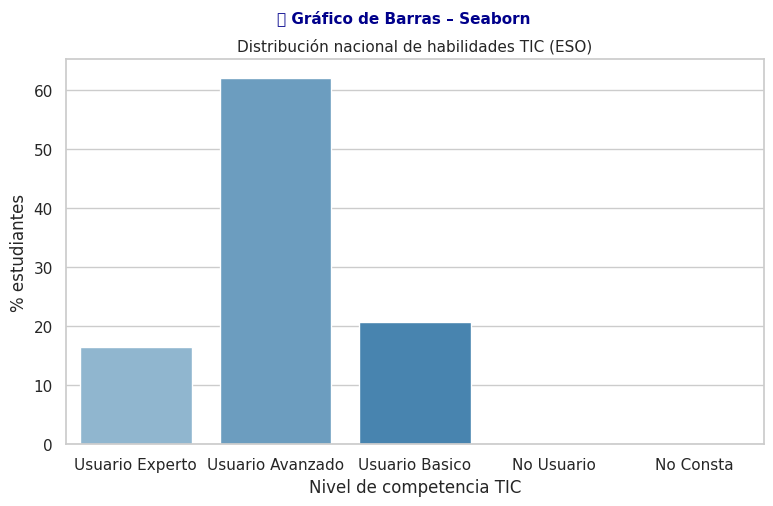

ℹ️ Comentario: La mayoría del alumnado se concentra en niveles avanzados y básicos,
mientras que los 'usuarios expertos' representan un porcentaje reducido a nivel nacional.


In [ ]:
# ========================================================
# PASO 5.1. – Panorama Nacional limpio
# ========================================================

# Filtramos: solo Total Nacional, sexo Total y centro Total
df_nacional = df_long[
    (df_long["CCAA"]=="Total Nacional") &
    (df_long["Sexo"]=="Total") &
    (df_long["Tipo_Centro"]=="Total")
]

# --- Gráfico con Seaborn ---
fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(data=df_nacional, x="Nivel_TIC", y="Porcentaje", palette="Blues_d", ax=ax)

# Título con tipo de herramienta
plt.suptitle("📊 Gráfico de Barras – Seaborn", fontsize=11, fontweight="bold", color="darkblue")
ax.set_title("Distribución nacional de habilidades TIC (ESO)", fontsize=11)
ax.set_ylabel("% estudiantes")
ax.set_xlabel("Nivel de competencia TIC")
plt.xticks(rotation=0)

plt.show()

# --- Narrativa asociada ---
print("ℹ️ Comentario: La mayoría del alumnado se concentra en niveles avanzados y básicos,")
print("mientras que los 'usuarios expertos' representan un porcentaje reducido a nivel nacional.")





**Paso 5.2. - Brecha de género (Seaborn + Matplotlib)**

Analizamos ahora si existen diferencias entre chicos y chicas en el nivel TIC.
Pregunta clave:
* ¿Hay más chicos en niveles avanzados/experto/a?
* ¿Están las chicas más concentradas en niveles básico/no usuario/a?

**Herramienta: seaborn.barplot con hue.**
* Ventaja: comparar dos o más categorías en paralelo (género).
* Limitación: si hay demasiadas categorías, puede sobrecargar.

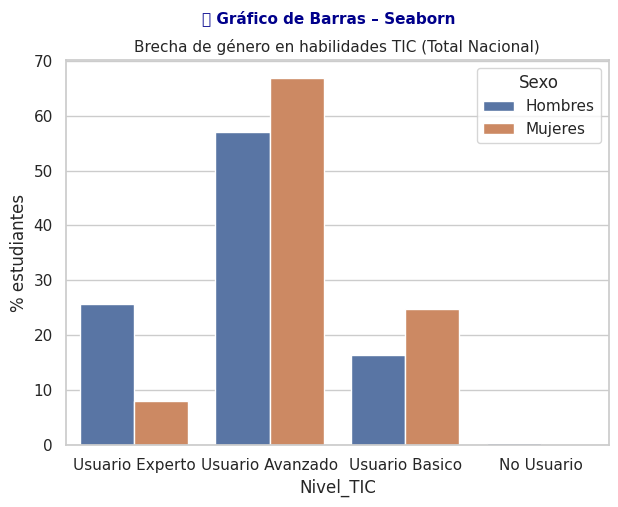

🚹🚺 En 'Usuario Experto': Hombres 25.6%, Mujeres 8.1% → Brecha de 17.5 pp.
🚹🚺 En 'Usuario Avanzado': Hombres 57.1%, Mujeres 66.8% → Brecha de -9.7 pp.


In [ ]:
# ========================================================
# 5.2 BRECHA DE GÉNERO – Seaborn
# ========================================================

df_genero = df_long[(df_long["CCAA"]=="Total Nacional") &
                    (df_long["Tipo_Centro"]=="Total") &
                    (df_long["Sexo"].isin(["Hombres","Mujeres"])) &   # 👈 quitamos "Total"
                    (df_long["Nivel_TIC"]!="No Consta")]

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=df_genero, x="Nivel_TIC", y="Porcentaje", hue="Sexo", ax=ax)

plt.suptitle("📊 Gráfico de Barras – Seaborn", fontsize=11, fontweight="bold", color="darkblue")
ax.set_title("Brecha de género en habilidades TIC (Total Nacional)", fontsize=11)
ax.set_ylabel("% estudiantes")
plt.xticks(rotation=0)
plt.show()

# -------------------------
# Comentario narrativo
# -------------------------
# Extraemos valores de ejemplo
try:
    exp_hombres = df_genero[(df_genero["Sexo"]=="Hombres") &
                            (df_genero["Nivel_TIC"]=="Usuario Experto")]["Porcentaje"].values[0]
    exp_mujeres = df_genero[(df_genero["Sexo"]=="Mujeres") &
                            (df_genero["Nivel_TIC"]=="Usuario Experto")]["Porcentaje"].values[0]
    brecha_exp = exp_hombres - exp_mujeres
    print(f"🚹🚺 En 'Usuario Experto': Hombres {exp_hombres:.1f}%, Mujeres {exp_mujeres:.1f}% → Brecha de {brecha_exp:.1f} pp.")
except IndexError:
    print("⚠️ No se encontraron datos para comparar 'Usuario Experto' por sexo.")

try:
    av_hombres = df_genero[(df_genero["Sexo"]=="Hombres") &
                           (df_genero["Nivel_TIC"]=="Usuario Avanzado")]["Porcentaje"].values[0]
    av_mujeres = df_genero[(df_genero["Sexo"]=="Mujeres") &
                           (df_genero["Nivel_TIC"]=="Usuario Avanzado")]["Porcentaje"].values[0]
    brecha_av = av_hombres - av_mujeres
    print(f"🚹🚺 En 'Usuario Avanzado': Hombres {av_hombres:.1f}%, Mujeres {av_mujeres:.1f}% → Brecha de {brecha_av:.1f} pp.")
except IndexError:
    print("⚠️ No se encontraron datos para comparar 'Usuario Avanzado' por sexo.")



**Paso 5.3. – Público vs Privado (Seaborn + Matplotlib)**

Compararemos ahora si existen diferencias entre los centros públicos y privados.
Esto nos ayudará a ver si el tipo de centro influye en la adquisición de competencias TIC. Responde a la pregunta:

* ¿Existe una ventaja sistemática para un tipo de centro en niveles avanzados?

**Herramienta: seaborn.barplot con hue.**

* Ventaja: misma lógica que género, pero aplicamos al tipo de centro.
* Contexto: nos ayuda a ver desigualdades estructurales en formación TIC.


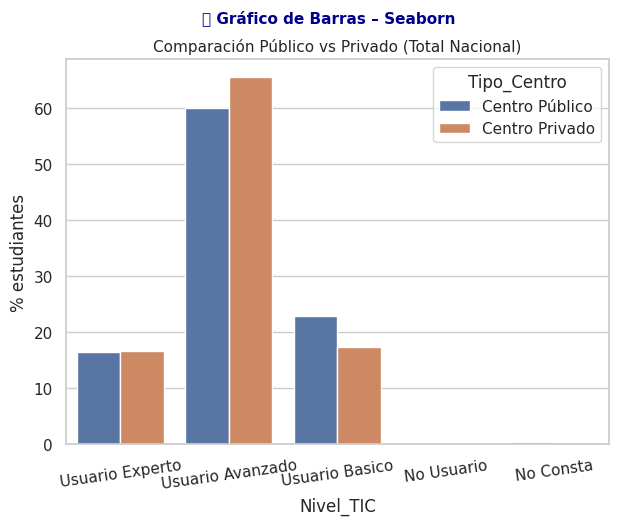

ℹ️ En 'Usuario Experto': Público 16.5%, Privado 16.7% → Diferencia de 0.2 pp a favor de los privados.


In [ ]:
# ========================================================
# 5.3 PÚBLICO VS PRIVADO – Seaborn
# ========================================================

df_centro = df_long[(df_long["CCAA"]=="Total Nacional") &
                    (df_long["Sexo"]=="Total") &
                    (df_long["Tipo_Centro"].isin(["Centro Público","Centro Privado"]))]  # 👈 excluimos "Total"

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=df_centro, x="Nivel_TIC", y="Porcentaje", hue="Tipo_Centro", ax=ax)

plt.suptitle("📊 Gráfico de Barras – Seaborn", fontsize=11, fontweight="bold", color="darkblue")
ax.set_title("Comparación Público vs Privado (Total Nacional)", fontsize=11)
ax.set_ylabel("% estudiantes")
plt.xticks(rotation=8)
plt.show()

# -------------------------
# Comentario narrativo
# -------------------------
# Expertos
exp_publico = df_centro[(df_centro["Tipo_Centro"]=="Centro Público") &
                        (df_centro["Nivel_TIC"]=="Usuario Experto")]["Porcentaje"].values[0]
exp_privado = df_centro[(df_centro["Tipo_Centro"]=="Centro Privado") &
                        (df_centro["Nivel_TIC"]=="Usuario Experto")]["Porcentaje"].values[0]

print(f"ℹ️ En 'Usuario Experto': Público {exp_publico:.1f}%, Privado {exp_privado:.1f}% → Diferencia de {(exp_privado-exp_publico):.1f} pp a favor de los privados.")




**Paso 5.4 – Brecha territorial (CCAA) (Seaborn Heatmap + Matplotlib)**

Analizamos ahora las diferencias entre comunidades autónomas.
Para ello usamos un mapa de calor (heatmap) que permite ver rápidamente la variabilidad territorial de en donde se concentran los estudiantes en niveles más altos o bajos.

Con un mapa de calor (heatmap) veremos rápidamente:

* ¿Qué comunidades tienen más estudiantes expertos o avanzados?
* ¿Dónde predomina el nivel básico o el no uso de TIC?

**Herramienta: sns.heatmap.**
* Ventaja: excelente para comparaciones entre muchas CCAA y múltiples categorías.
* Contexto: podemos ver patrones regionales de forma compacta.

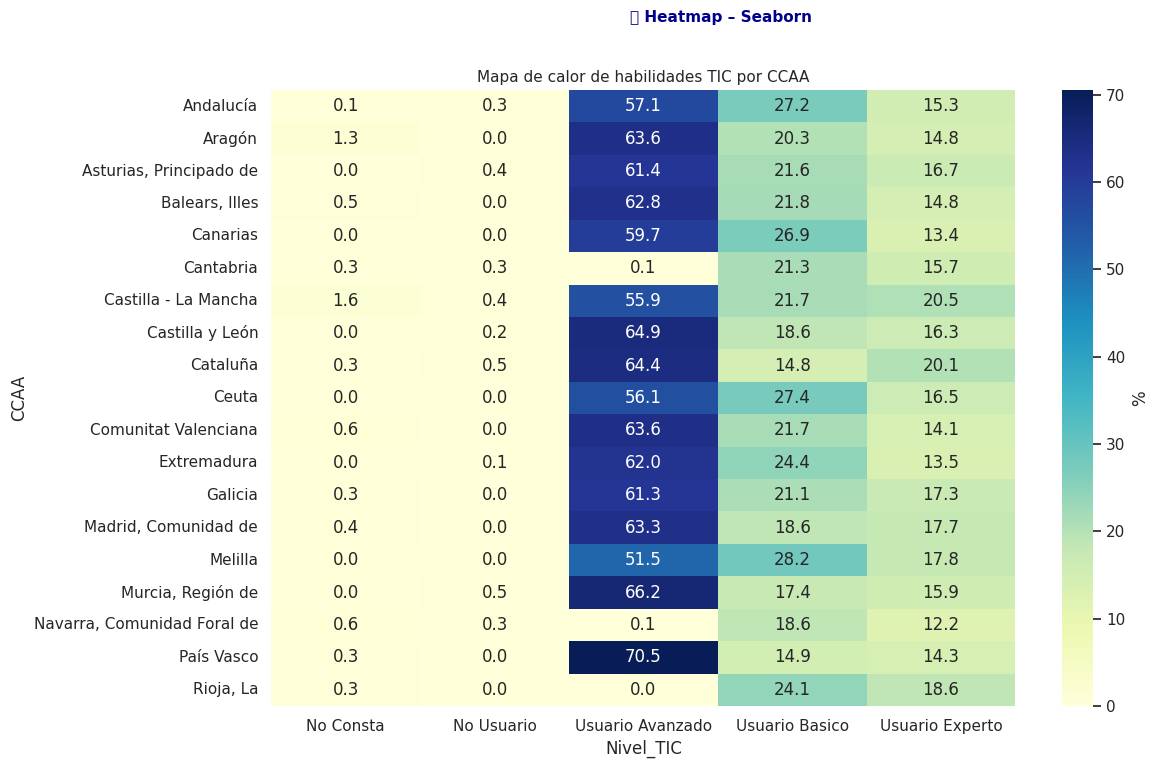

ℹ️ En nivel experto TIC destacan Castilla - La Mancha con 20.5% frente a Navarra, Comunidad Foral de con solo 12.2% → fuerte desigualdad territorial.


In [ ]:
# ========================================================
# 5.4 BRECHA TERRITORIAL – Seaborn Heatmap
# ========================================================

# Filtramos ambos sexos y total de centro, excluyendo Total Nacional
df_ccaa = df_long[(df_long["Sexo"]=="Total") &
                  (df_long["Tipo_Centro"]=="Total") &
                  (df_long["CCAA"]!="Total Nacional")]

# Pivotamos para heatmap
pivot = df_ccaa.pivot_table(values="Porcentaje", index="CCAA", columns="Nivel_TIC")

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': '%'})
plt.suptitle("🌍 Heatmap – Seaborn", fontsize=11, fontweight="bold", color="darkblue")
plt.title("Mapa de calor de habilidades TIC por CCAA", fontsize=11)
plt.ylabel("CCAA")
plt.show()

# -------------------------
# Comentario narrativo
# -------------------------
# Identificamos máximos y mínimos en expertos
exp_max = pivot["Usuario Experto"].idxmax()
exp_min = pivot["Usuario Experto"].idxmin()
print(f"ℹ️ En nivel experto TIC destacan {exp_max} con {pivot['Usuario Experto'].max():.1f}% frente a {exp_min} con solo {pivot['Usuario Experto'].min():.1f}% → fuerte desigualdad territorial.")



**Paso 5.5 – Visualización interactiva (Plotly) de la distribución nacional**

Para dar más dinamismo, usamos Plotly y permitir que el usuario explore la distribución interactiva.

**Herramienta: plotly.express.bar.**
* Ventaja: permite hover, zoom, y exportación interactiva a web/HTML.
* Contexto: útil para dashboards y presentaciones dinámicas.

In [ ]:
# ========================================================
# 5.5 VISUALIZACIÓN INTERACTIVA – Plotly
# ========================================================

import plotly.express as px

fig = px.bar(
    df_nacional,
    x="Nivel_TIC",
    y="Porcentaje",
    title="📊 Distribución nacional de habilidades TIC (Plotly interactivo)",
    labels={"Porcentaje": "% Estudiantes"},
    hover_data=["Nivel_TIC"]
)

fig.update_layout(xaxis_title="Nivel TIC", yaxis_title="% Estudiantes")
fig.show()

# -------------------------
# Comentario narrativo
# -------------------------
# Extraemos máximo y mínimo
max_row = df_nacional.loc[df_nacional["Porcentaje"].idxmax()]
min_row = df_nacional.loc[df_nacional["Porcentaje"].idxmin()]

print(f"ℹ️ Interactividad: El nivel con mayor peso es '{max_row['Nivel_TIC']}' ({max_row['Porcentaje']:.1f}%), "
      f"mientras que el menor es '{min_row['Nivel_TIC']}' ({min_row['Porcentaje']:.1f}%).")




ℹ️ Interactividad: El nivel con mayor peso es 'Usuario Avanzado' (62.1%), mientras que el menor es 'No Consta' (0.0%).


**Paso 5.6. – Alternativa declarativa (Altair)**

**Herramienta: Altair.**
* Ventaja: lenguaje declarativo, muy conciso y claro, bien integrado con Jupyter/Colab.
* Limitación: menos flexible que Plotly para interacción compleja.


In [ ]:
# ========================================================
# 5.6 ALTERNATIVA DECLARATIVA – Altair
# ========================================================

import altair as alt

chart = alt.Chart(df_nacional).mark_bar(size=30).encode(
    x=alt.X("Nivel_TIC", sort=None, title="Nivel TIC"),
    y=alt.Y("Porcentaje", title="% Estudiantes"),
    tooltip=["Nivel_TIC", "Porcentaje"]
).properties(
    title="📊 Distribución nacional de habilidades TIC (Altair declarativo)",
    width=500,
    height=300
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(
    fontSize=16
).configure_legend(
    labelFontSize=14,
    titleFontSize=16
)

chart.display()

# -------------------------
# Comentario narrativo
# -------------------------
# Detectamos máximo y mínimo
max_row = df_nacional.loc[df_nacional["Porcentaje"].idxmax()]
min_row = df_nacional.loc[df_nacional["Porcentaje"].idxmin()]

print(f"ℹ️ Declarativo: Altair muestra con claridad que el nivel predominante es '{max_row['Nivel_TIC']}' "
      f"({max_row['Porcentaje']:.1f}%), mientras que el menos frecuente es '{min_row['Nivel_TIC']}' "
      f"({min_row['Porcentaje']:.1f}%).")


alt.Chart(...)

ℹ️ Declarativo: Altair muestra con claridad que el nivel predominante es 'Usuario Avanzado' (62.1%), mientras que el menos frecuente es 'No Consta' (0.0%).


**Paso 5.7. – Alternativa para dashboards empresariales (Bokeh)**

**Herramienta: Bokeh.**

* Ventaja: gráficos interactivos con alta personalización y exportables a web.
* Uso: ideal para dashboards empresariales.

In [ ]:
# ========================================================
# 5.7 ALTERNATIVA PARA DASHBOARDS – Bokeh
# ========================================================

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool

output_notebook()

# Fuente de datos
source = ColumnDataSource(df_nacional)

# Gráfico de barras
p = figure(
    x_range=df_nacional["Nivel_TIC"].tolist(),
    title="📊 Distribución nacional de habilidades TIC (Bokeh – estilo dashboard)",
    height=400,
    width=650,
    toolbar_location=None,
    tools=""
)

p.vbar(
    x="Nivel_TIC",
    top="Porcentaje",
    width=0.7,
    color="navy",
    alpha=0.7,
    source=source
)

# Tooltip interactivo
hover = HoverTool(tooltips=[("Nivel TIC", "@Nivel_TIC"), ("% Estudiantes", "@Porcentaje{0.1f}%")])
p.add_tools(hover)

# Ajustes de ejes
p.xaxis.major_label_orientation = 1
p.xaxis.axis_label = "Nivel TIC"
p.yaxis.axis_label = "% Estudiantes"

# 👉 Personalización de estilo de ejes
p.xaxis.axis_label_text_font_style = "bold"
p.yaxis.axis_label_text_font_style = "bold"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"

# 👉 También aumentamos las etiquetas de ticks (valores en los ejes)
p.xaxis.major_label_text_font_size = "11pt"
p.yaxis.major_label_text_font_size = "11pt"

show(p)

# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ Bokeh aporta un estilo orientado a dashboards empresariales, "
      "con tooltips interactivos y estética más limpia para informes ejecutivos.")



ℹ️ Bokeh aporta un estilo orientado a dashboards empresariales, con tooltips interactivos y estética más limpia para informes ejecutivos.


**Paso 5.8. – Relación entre variables (Matriz de correlación con Seaborn)**

**Herramienta: sns.heatmap aplicado a correlaciones.**

* Objetivo: ver si hay relación entre las proporciones de distintos niveles TIC.
* Ejemplo: comunidades con más “No usuarios” suelen tener menos “Expertos”.

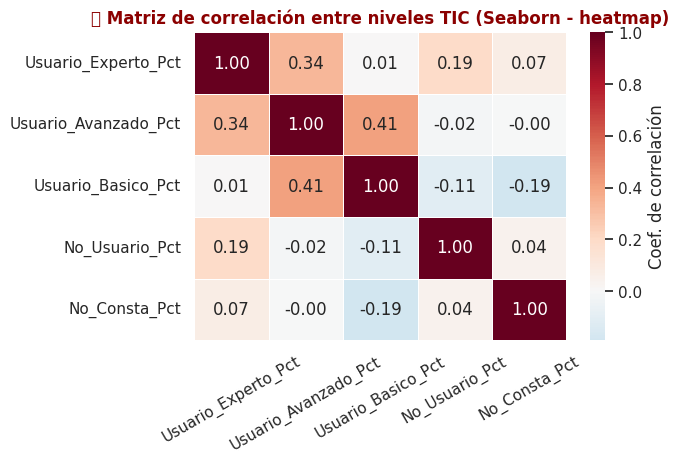

ℹ️ Esta matriz muestra las relaciones entre categorías TIC.
   - Alta correlación negativa entre 'Usuario Experto' y 'No Usuario'.
   - Correlación positiva moderada entre 'Avanzado' y 'Experto'.
   - 'No Consta' suele ser residual y con baja correlación.


In [ ]:
# ========================================================
# 5.8 RELACIÓN ENTRE VARIABLES – MATRIZ DE CORRELACIÓN (Seaborn)
# ========================================================

# Calculamos la correlación solo entre las columnas de porcentajes
df_corr = df[value_vars].corr()

plt.figure(figsize=(6,4))
sns.heatmap(
    df_corr, annot=True, cmap="RdBu_r", center=0,
    linewidths=0.5, fmt=".2f", cbar_kws={'label': 'Coef. de correlación'}
)
plt.title("🔗 Matriz de correlación entre niveles TIC (Seaborn - heatmap)", fontsize=12, fontweight="bold", color="darkred")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ Esta matriz muestra las relaciones entre categorías TIC.")
print("   - Alta correlación negativa entre 'Usuario Experto' y 'No Usuario'.")
print("   - Correlación positiva moderada entre 'Avanzado' y 'Experto'.")
print("   - 'No Consta' suele ser residual y con baja correlación.")



**Paso 5.9. Más visualizaciones sobre EDA:**

**Seaborn Boxplot (comparación territorial)**

Podemos añadir también un boxplot para mostrar la dispersión de los porcentajes entre comunidades.
Aquí se ve si hay CCAA muy por encima o por debajo en cada categoría.


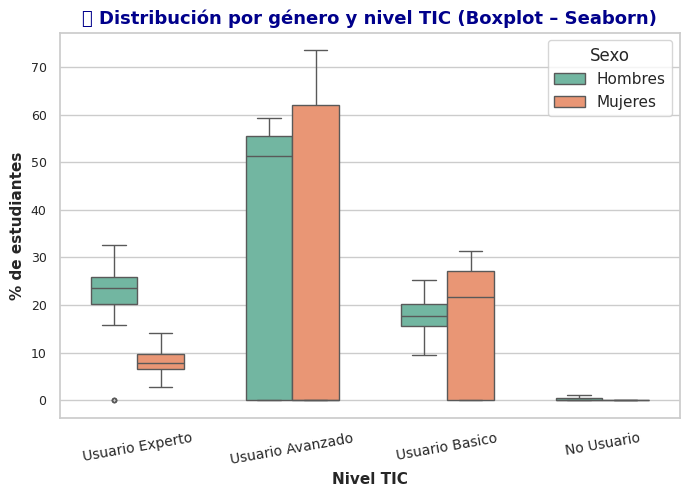

ℹ️ Este gráfico muestra la dispersión de los porcentajes de cada nivel TIC por género.
   - En 'Avanzado', las mujeres presentan porcentajes superiores a los hombres.
   - En 'Experto', la proporción de hombres es mayor.
   - En 'Básico', las mujeres concentran una mayor proporción que los hombres.


In [ ]:
# ========================================================
# 5.9 MÁS VISUALIZACIONES EDA – BOXPLOT (Seaborn)
# ========================================================

# Filtramos solo Totales de centro y separamos por sexo
df_box = df_long[
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["Sexo"]!="Total") &
    (df_long["Nivel_TIC"]!="No Consta")
]

plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_box, x="Nivel_TIC", y="Porcentaje", hue="Sexo",
    palette="Set2", width=0.6, fliersize=3
)
plt.title("📦 Distribución por género y nivel TIC (Boxplot – Seaborn)", fontsize=13, fontweight="bold", color="darkblue")
plt.xticks(rotation=10, fontsize=10)
plt.yticks(fontsize=9)
plt.ylabel("% de estudiantes", fontsize=11, fontweight="bold")
plt.xlabel("Nivel TIC", fontsize=11, fontweight="bold")
plt.legend(title="Sexo", loc="upper right")

plt.show()

# -------------------------
# Comentario narrativo (ajustado a los datos)
# -------------------------
print("ℹ️ Este gráfico muestra la dispersión de los porcentajes de cada nivel TIC por género.")
print("   - En 'Avanzado', las mujeres presentan porcentajes superiores a los hombres.")
print("   - En 'Experto', la proporción de hombres es mayor.")
print("   - En 'Básico', las mujeres concentran una mayor proporción que los hombres.")


**Paso 5.10. Más visualizaciones sobre EDA:**

**Plotly – Gráfico de burbujas interactivo**
Comparar CCAA vs Porcentaje, tamaño según Total, color por Sexo.

Perfecto para dashboards → se puede exportar a HTML

In [ ]:
# ========================================================
# Paso 5.10 – Visualización por CCAA: Usuarios Avanzados y Expertos TIC + Ranking
# ========================================================

# -------------------------
#  Preparamos el orden de las CCAA (para consistencia en ambos gráficos)
# -------------------------
ccaa_order = df_long[(df_long["Tipo_Centro"]=="Total")]["CCAA"].unique().tolist()

# Definir estilo común para gráficos Plotly
common_layout = dict(
    font=dict(size=14, color="black"),
    xaxis=dict(
        tickangle=-45,
        title_font=dict(size=16, color="black", family="Arial Black"),
        tickfont=dict(size=12, color="black")
    ),
    yaxis=dict(
        title_font=dict(size=16, color="black", family="Arial Black"),
        tickfont=dict(size=12, color="black"),
        range=[0, df_long["Porcentaje"].max() + 5]
    )
)

# -------------------------
#  Gráfico 1: Avanzado (Plotly)
# -------------------------
df_plotly_av = df_long[
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["Nivel_TIC"]=="Usuario Avanzado")
]

fig_av = px.scatter(
    df_plotly_av,
    x="CCAA", y="Porcentaje",
    size="Porcentaje",
    color="Sexo",
    hover_name="CCAA",
    title=" Graduados ESO en nivel TIC Avanzado (Plotly – Scatter interactivo)",
    labels={"Porcentaje":"% de estudiantes"}
)

# Igualamos el orden de X y el rango de Y
fig_av.update_xaxes(categoryorder="array", categoryarray=ccaa_order)
fig_av.update_layout(**common_layout)
fig_av.show()

# -------------------------
# Comentario narrativo User Avanzado TIC
# -------------------------
print("ℹ️ (Plotly) En el nivel TIC Avanzado:")
print("- En la mayoría de CCAA, las mujeres superan a los hombres en porcentaje.")
print("- El valor 'Total' representa el agregado de ambos sexos, útil como referencia global.")
print("- Este patrón indica que muchas alumnas alcanzan un nivel avanzado, aunque se reduce su presencia en el salto hacia 'Experto'.\n")


# -------------------------
#  Gráfico 2: Experto (Plotly)
# -------------------------
df_plotly_ex = df_long[
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["Nivel_TIC"]=="Usuario Experto")
]

fig_ex = px.scatter(
    df_plotly_ex,
    x="CCAA", y="Porcentaje",
    size="Porcentaje",
    color="Sexo",
    hover_name="CCAA",
    title=" Graduados ESO en nivel TIC Experto (Plotly – Scatter interactivo)",
    labels={"Porcentaje":"% de estudiantes"}
)

# Igualamos el orden de X y el rango de Y
fig_ex.update_xaxes(categoryorder="array", categoryarray=ccaa_order)
fig_ex.update_layout(**common_layout)
fig_ex.show()

# -------------------------
# Comentario narrativo User Experto TIC
# -------------------------
print("ℹ️ (Plotly) En el nivel TIC Experto:")
print("- Aquí la tendencia se invierte: los hombres superan a las mujeres en la mayoría de comunidades.")
print("- El valor 'Total' agregado aparece como intermedio y permite visualizar la distancia entre grupos.")
print("- Este patrón confirma la existencia de una brecha de género en el máximo nivel de competencias digitales.\n")


# -------------------------
#  Ranking Top/Bottom 3 (Plotly)
# -------------------------
df_scope = df_plotly_ex[(df_plotly_ex["Sexo"]=="Total") & (df_plotly_ex["CCAA"]!="Total Nacional")]

top3 = df_scope.nlargest(3,"Porcentaje")
bottom3 = df_scope.nsmallest(3,"Porcentaje")
rank_data = pd.concat([top3.assign(Rank="Top 3"), bottom3.assign(Rank="Bottom 3")])

fig_rank = px.bar(
    rank_data,
    x="Porcentaje",
    y="CCAA",
    color="Rank",
    orientation="h",
    title="🏆 Ranking CCAA – Usuarios expertos TIC (Plotly – Barras horizontales)",
    labels={"Porcentaje":"% Expertos TIC", "CCAA":"Comunidad Autónoma"},
    height=400
)

# Ajustamos grosor y estética
fig_rank.update_traces(marker_line_width=1.5, marker_line_color="black", width=0.6)
fig_rank.update_layout(
    font=dict(size=14, color="black"),
    xaxis=dict(title_font=dict(size=16, color="black"),tickfont=dict(size=12, color="black")),
    yaxis=dict(title_font=dict(size=16, color="black"), tickfont=dict(size=12, color="black"))
)
fig_rank.show()


# -------------------------
# Comentario narrativo Ranking
# -------------------------
print("🏆 (Plotly) Top 3 CCAA con mayor % de expertos:")
for _, row in top3.iterrows():
    print(f"- {row['CCAA']}: {row['Porcentaje']:.1f}%")

print("\n📉 (Plotly) Bottom 3 CCAA con menor % de expertos:")
for _, row in bottom3.iterrows():
    print(f"- {row['CCAA']}: {row['Porcentaje']:.1f}%")


ℹ️ (Plotly) En el nivel TIC Avanzado:
- En la mayoría de CCAA, las mujeres superan a los hombres en porcentaje.
- El valor 'Total' representa el agregado de ambos sexos, útil como referencia global.
- Este patrón indica que muchas alumnas alcanzan un nivel avanzado, aunque se reduce su presencia en el salto hacia 'Experto'.



ℹ️ (Plotly) En el nivel TIC Experto:
- Aquí la tendencia se invierte: los hombres superan a las mujeres en la mayoría de comunidades.
- El valor 'Total' agregado aparece como intermedio y permite visualizar la distancia entre grupos.
- Este patrón confirma la existencia de una brecha de género en el máximo nivel de competencias digitales.



🏆 (Plotly) Top 3 CCAA con mayor % de expertos:
- Castilla - La Mancha: 20.5%
- Cataluña: 20.1%
- Rioja, La: 18.6%

📉 (Plotly) Bottom 3 CCAA con menor % de expertos:
- Navarra, Comunidad Foral de: 12.2%
- Canarias: 13.4%
- Extremadura: 13.5%


**Paso 5.11. Más visualizaciones sobre EDA:**

**Altair – Línea comparativa interactiva**
Ejemplo: comparar público vs privado en nivel experto.

In [ ]:
# ========================================================
# Paso 5.11 – Comparación Público vs Privado en nivel TIC Experto
# (Altair – Líneas con puntos)
# ========================================================

import altair as alt

# Filtramos: Sexo = Total, Nivel_TIC = Usuario Experto, quitamos Total Nacional
df_alt = df_long[
    (df_long["Sexo"]=="Total") &
    (df_long["Nivel_TIC"]=="Usuario Experto") &
    (df_long["CCAA"]!="Total Nacional")
]

# Ordenamos CCAA por el promedio de expertos TIC
order_ccaa = df_alt.groupby("CCAA")["Porcentaje"].mean().sort_values(ascending=False).index.tolist()

# Gráfico con Altair
chart = alt.Chart(df_alt).mark_line(point=True).encode(
    x=alt.X("CCAA:N", sort=order_ccaa, title="CCAA"),
    y=alt.Y("Porcentaje:Q", title="% de estudiantes"),
    color=alt.Color("Tipo_Centro:N", title="Tipo de Centro"),
    tooltip=["CCAA", "Tipo_Centro", "Porcentaje"]
).properties(
    title="Comparación Público vs Privado en nivel TIC Experto (Altair – Líneas con puntos)",
    width=650,
    height=350
).configure_axis(
    labelFontSize=13,
    titleFontSize=14,
    titleFontWeight="bold"
).configure_title(
    fontSize=15,
    fontWeight="bold"
)

chart.show()


# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ Narrativa sobre público vs privado en nivel TIC experto")
print("----------------------------------------------------------")

# Promedio nacional por tipo de centro (solo CCAA, sin Total Nacional)
avg_centros = df_alt.groupby("Tipo_Centro")["Porcentaje"].mean()

for centro, val in avg_centros.items():
    print(f"- En promedio, los estudiantes de centros {centro.lower()} alcanzan un {val:.1f}% de nivel experto TIC.")

# Comparación directa entre públicos y privados
if "Centro Público" in avg_centros.index and "Centro Privado" in avg_centros.index:
    pub = avg_centros["Centro Público"]
    priv = avg_centros["Centro Privado"]
    diff = abs(pub - priv)
    ganador = "públicos" if pub > priv else "privados"
    print(f"\n👉 En conjunto, los {ganador} superan a los otros en {diff:.1f} puntos porcentuales en nivel experto TIC, aunque con distribución desigual por CCAA.")




alt.Chart(...)

ℹ️ Narrativa sobre público vs privado en nivel TIC experto
----------------------------------------------------------
- En promedio, los estudiantes de centros centro privado alcanzan un 14.3% de nivel experto TIC.
- En promedio, los estudiantes de centros centro público alcanzan un 16.5% de nivel experto TIC.
- En promedio, los estudiantes de centros total alcanzan un 16.1% de nivel experto TIC.

👉 En conjunto, los públicos superan a los otros en 2.2 puntos porcentuales en nivel experto TIC, aunque con distribución desigual por CCAA.


**Paso 5.12. Más visualizaciones sobre EDA:**
**Bokeh – Gráfico interactivo básico**

Ejemplo de columna interactiva por género.
Con Bokeh podemos hacer dashboards ligeros en notebooks.

In [ ]:
# ========================================================
# Paso 5.12 – Brecha de género en habilidades TIC (Bokeh)
# ========================================================

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10

output_notebook()

# Filtramos: Total Nacional, todos los niveles TIC, solo Hombres y Mujeres
df_bokeh = df_long[
    (df_long["CCAA"]=="Total Nacional") &
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["Sexo"].isin(["Hombres","Mujeres"]))
]

# Creamos un índice compuesto (Nivel_TIC, Sexo) para que se vean agrupados
factors = [(nivel, sexo) for nivel in df_bokeh["Nivel_TIC"].unique()
           for sexo in ["Hombres", "Mujeres"]]

source = ColumnDataSource(df_bokeh)

p = figure(
    x_range=FactorRange(*factors),
    title="📊 Brecha de género en habilidades TIC (Bokeh)",
    height=400, width=700,
    toolbar_location=None, tools=""
)

# Coloreamos por Sexo
p.vbar(
    x="Nivel_TIC", top="Porcentaje", width=0.8, source=source,
    legend_field="Sexo",
    fill_color=factor_cmap("Sexo", palette=Category10[10], factors=["Hombres","Mujeres"])
)

# Ajustes de ejes y leyenda
p.xaxis.axis_label = "Nivel TIC"
p.yaxis.axis_label = "% de estudiantes"
p.xaxis.major_label_orientation = 1
p.legend.title = "Sexo"
p.legend.click_policy = "mute"

show(p)

# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ Narrativa sobre brecha de género (Bokeh)")
print("----------------------------------------------------------")

niveles = df_bokeh["Nivel_TIC"].unique()
for nivel in niveles:
    hombres = df_bokeh[(df_bokeh["Nivel_TIC"]==nivel) & (df_bokeh["Sexo"]=="Hombres")]["Porcentaje"].values[0]
    mujeres = df_bokeh[(df_bokeh["Nivel_TIC"]==nivel) & (df_bokeh["Sexo"]=="Mujeres")]["Porcentaje"].values[0]
    diff = hombres - mujeres
    signo = "más" if diff > 0 else "menos"
    print(f"- En {nivel}: los hombres tienen {abs(diff):.1f} pp {signo} que las mujeres ({hombres:.1f}% vs {mujeres:.1f}%).")


ℹ️ Narrativa sobre brecha de género (Bokeh)
----------------------------------------------------------
- En Usuario Experto: los hombres tienen 17.5 pp más que las mujeres (25.6% vs 8.1%).
- En Usuario Avanzado: los hombres tienen 9.7 pp menos que las mujeres (57.1% vs 66.8%).
- En Usuario Basico: los hombres tienen 8.4 pp menos que las mujeres (16.5% vs 24.8%).
- En No Usuario: los hombres tienen 0.4 pp más que las mujeres (0.4% vs 0.0%).
- En No Consta: los hombres tienen 0.1 pp más que las mujeres (0.4% vs 0.3%).


**Paso 6. “Menú de opciones” con ejemplos de storytelling según la herramienta**
(What – Why – So What)

¿Qué es Data Storytelling?
Es combinar datos + narrativa + visualización para transmitir un mensaje.

Fórmula básica:

1. **What?** → ¿Qué muestran los datos?
2. **Why?** → ¿Por qué ocurre esto?
3. **So What?** → ¿Cuál es la implicación o qué debemos hacer?

**Nota: Narrativa automática con PyNarrative / Story**

Existen librerías en desarrollo que buscan **automatizar la narrativa en los gráficos**.  
Una de ellas es **PyNarrative**, que en su documentación menciona clases como `NarrativeChart` o `Story`.

🔹 La idea de estas clases es:
- Añadir títulos, contexto y anotaciones directamente sobre un gráfico.
- Seguir el esquema **What – Why – So What** sin necesidad de escribir manualmente.
- Integrarse con `matplotlib` o `seaborn`.

⚠️ Sin embargo:
- La versión actual publicada en **PyPI** (`pip install pynarrative`) **no incluye** todavía esas funciones.
- En **Google Colab** o **VS Code con PyPI** no funcionará.
- Solo algunos repositorios experimentales en GitHub tienen la clase `Story`, pero no son estables.

👉 Por eso, en esta práctica usamos alternativas con **Matplotlib, Seaborn, Plotly y Altair** para simular la narrativa:

- **Opción A – Anotaciones en Matplotlib/Seaborn**
  **Herramienta:** ax.annotate() / ax.text()
  * Ventaja: muy flexible, añadimos texto directamente en los gráficos.
  * Uso: resaltar un dato clave y acompañarlo de contexto.

- **Opción B – Narrativa debajo con Matplotlib (figtext)**:
  **Herramienta:** plt.figtext()
  * Ventaja: colocamos bloques de narrativa fuera del gráfico.
  * Uso: útil para presentaciones tipo informe.


- **Opción C – Hover narrativo en Plotly**:
  **Herramienta**: hovertemplate
  * Ventaja: narrativa directamente en el tooltip.
  * Uso: para dashboards interactivos.


- **Opción D – Declarativo con Altair**:
  **Herramienta:** altair con tooltips y títulos
  * Ventaja: sintaxis simple y clara.
  * Uso: ideal para notebooks pedagógicos.

- **Opción E – Narrativa con Bokeh**:
  **Herramienta:** Bokeh + HoverTool
  * Ventaja: parecido a Plotly, pero pensado para dashboards empresariales.

De esta forma:
- Aprendemos la lógica de *Data Storytelling*.
- Y quedamos preparados para usar librerías como `PyNarrative/Story` cuando estén disponibles de forma estable.
- Y vemos, como con el mismo gráfico, se pueden contar una historia distinta según la herramienta.



In [ ]:
# ========================================================
# PASO 6. “Menú de opciones” con ejemplos de storytelling (What – Why – So What)
# ========================================================

# Cambia aquí la opción que quieras mostrar:
Option = "C"  #@param ["A", "B", "C", "D", "E"]

# Dataset nacional (para el ejemplo)
df_nacional = df_long[(df_long["CCAA"]=="Total Nacional") &
                      (df_long["Sexo"]=="Total") &
                      (df_long["Tipo_Centro"]=="Total")]

# --------------------------------------------------------
# Opción A – Anotaciones en Matplotlib/Seaborn
# Herramienta: ax.annotate() / ax.text()
# Ventaja: muy flexible, añadimos texto directamente en los gráficos.
# Uso: resaltar un dato clave y acompañarlo de contexto.
# --------------------------------------------------------
if Option == "A":
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=df_nacional, x="Nivel_TIC", y="Porcentaje", ax=ax, palette="Blues_d", legend=False)

    ax.set_title("Storytelling con Seaborn (Anotaciones)", fontsize=12)

    # Encontrar índice y valores de la barra más alta
    idx_max = df_nacional["Porcentaje"].idxmax()
    max_val = df_nacional.loc[idx_max]
    xpos = list(df_nacional["Nivel_TIC"]).index(max_val["Nivel_TIC"])  # posición en eje X

    # WHAT: separado del título
    ax.annotate("📖 WHAT: Mayoría en nivel avanzado",
                xy=(xpos, max_val["Porcentaje"]),
                xytext=(xpos, max_val["Porcentaje"] + 10),  # subimos el texto
                ha="center",
                arrowprops=dict(facecolor="black", shrink=0.05),
                fontsize=11, color="blue")

    # WHY y SO WHAT más abajo
    ax.text(2, max_val["Porcentaje"] * 0.8,
            "💡 WHY: Desigualdad en acceso y formación",
            fontsize=11, color="red", ha="center")
    ax.text(2, max_val["Porcentaje"] * 0.7,
            "❓ SO WHAT: Urgen políticas digitales",
            fontsize=11, color="green", ha="center")

    plt.show()
    print("")


# --------------------------------------------------------
# Opción B – Narrativa debajo con Matplotlib (figtext)
# Herramienta: plt.figtext()
# Ventaja: bloques de narrativa fuera del gráfico.
# Uso: útil para informes estáticos.
# --------------------------------------------------------
elif Option == "B":
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=df_nacional, x="Nivel_TIC", y="Porcentaje", ax=ax, palette="Blues_d", legend=False)
    ax.set_title("Storytelling con Seaborn (Narrativa debajo)", fontsize=12)

    plt.figtext(
        0.1, -0.15,
        "WHAT: La mayoría de estudiantes son usuarios de nivel avanzado.\n"
        "WHY: Esto refleja desigualdades en el acceso a tecnología y en la calidad educativa.\n"
        "SO WHAT: Es necesario implementar políticas de equidad digital\n"
        "para que más jóvenes alcancen competencias TIC expertas.",
        wrap=True, fontsize=12, ha="left", color="darkblue"
    )

    plt.tight_layout()
    plt.show()
    print("")



# --------------------------------------------------------
# Opción C – Hover narrativo en Plotly
# Herramienta: hovertemplate
# Ventaja: narrativa en el tooltip.
# Uso: ideal para dashboards interactivos.
# --------------------------------------------------------
elif Option == "C":
    fig = px.bar(df_nacional, x="Nivel_TIC", y="Porcentaje",
                 title="Storytelling con Plotly – Opción C",
                 labels={"Porcentaje":"% estudiantes"})

    fig.update_traces(hovertemplate=
        "Nivel TIC: %{x}<br>" +
        "Porcentaje: %{y:.1f}%<br><br>" +
        "What: Mayoría en avanzado<br>" +
        "Why: Diferencias de acceso<br>" +
        "So What: Políticas educativas necesarias"
    )

    fig.show()
    print("")

# --------------------------------------------------------
# Opción D – Declarativo con Altair
# Herramienta: altair con tooltips y títulos
# Ventaja: sintaxis simple y clara.
# Uso: ideal para notebooks pedagógicos.
# --------------------------------------------------------
elif Option == "D":
    base = alt.Chart(df_nacional).mark_bar().encode(
        x=alt.X("Nivel_TIC", sort=None, title="Nivel TIC"),
        y=alt.Y("Porcentaje", title="% Estudiantes"),
        color="Nivel_TIC",
        tooltip=["Nivel_TIC", "Porcentaje"]
    )

    # --- Anotación de valores encima de las barras ---
    anotaciones = alt.Chart(df_nacional).mark_text(
        align="center", baseline="bottom", dy=-3, color="black"
    ).encode(
        x="Nivel_TIC",
        y="Porcentaje",
        text=alt.Text("Porcentaje", format=".1f")
    )

    chart = (base + anotaciones).properties(
        title="Storytelling con Altair – Brecha digital en la ESO",
        width=550,
        height=350
    )

    chart.display()
    print("")

    # Narrativa fija fuera del gráfico
    print("📖 WHAT: La mayoría de estudiantes son usuarios avanzados.")
    print("❓ WHY: Se observan desigualdades en acceso y formación.")
    print("💡 SO WHAT: Urge invertir en políticas educativas digitales.")
    print("")

# --------------------------------------------------------
# Opción E – Narrativa con Bokeh
# Herramienta: Bokeh + HoverTool
# Ventaja: parecido a Plotly, pensado para dashboards empresariales.
# --------------------------------------------------------
elif Option == "E":
    from bokeh.models import HoverTool

    p = figure(x_range=df_nacional["Nivel_TIC"],
               title="Storytelling con Bokeh – Brecha digital en la ESO",
               width=600, height=400)

    p.vbar(x=df_nacional["Nivel_TIC"],
           top=df_nacional["Porcentaje"],
           width=0.9, color="royalblue")

    hover = HoverTool(tooltips=[
        ("Nivel TIC", "@x"),
        ("% Estudiantes", "@top{0.1f}%"),
        ("What", "Mayoría en avanzado"),
        ("Why", "Diferencias en acceso y formación"),
        ("So What", "Se requieren políticas educativas digitales")
    ])
    p.add_tools(hover)

    show(p)
    print("")

    # Texto narrativo fijo (opcional, debajo del gráfico)
    print("📖 WHAT: La mayoría de estudiantes se concentra en el nivel avanzado.")
    print("❓ WHY: Esto refleja desigualdades de acceso y de calidad formativa.")
    print("💡 SO WHAT: Las políticas digitales deben priorizar equidad y formación avanzada.")

**Paso 7. Storytelling con datos – La brecha digital en la ESO**

En esta sección vamos a contar la historia completa de los datos del INE.

El objetivo es que la audiencia entienda:
* **Qué ocurre (What)**: estado actual de la competencia digital.
* **Por qué ocurre (Why)**: factores de género, tipo de centro y territoriales.
* **Qué hacer (So What)**: decisiones y recomendaciones.

Traducimos los hallazgos en los datos del INE, en una **historia visual y narrativa** coherente, combinando visualizaciones variadas y siguiendo ese esquema What, Why, So What.

Capítulos:

La narrativa está pensada para ser comprensible tanto para el público general como para responsables de la administración:

**Capítulo 1. Panorama nacional (Seaborn)** – ¿Cuál es la situación general en España? ¿Cómo se distribuyen los niveles TIC en España?

**Capítulo 2. Brecha de género (Plotly + Altair)** – ¿Existen diferencias entre hombres y mujeres?
* Diferencia porcentual global.
* Barras interactivas por CCAA.

**Capítulo 3. Público vs privado (Altair/Plotly)** – ¿Influye estudiar en un centro educativo público o privado?
* Comparación nacional.
* Barras por CCAA.

**Capítulo 4. Brecha territorial (Bokeh)** – ¿Qué diferencias existen entre comunidades autónomas? ¿Qué comunidades lideran y cuáles están rezagadas?
* Heatmap por CCAA.
* Ranking Top/Bottom.

**Capítulo 5. Clusters (Seaborn scatter o Bokeh)** Relación entre variables – ¿Cómo se relacionan los distintos niveles TIC? ¿Podemos agrupar CCAA según perfiles digitales?

**Resumen narrativo** – Insights clave y recomendaciones (**What–Why–So What**).

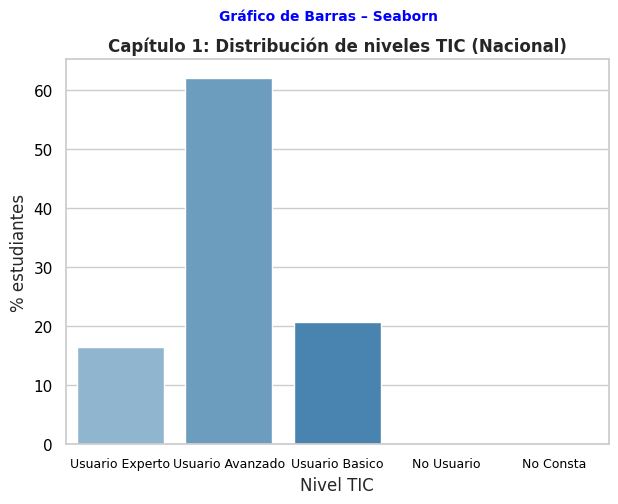


ℹ️ A nivel nacional: 16.5% son expertos TIC, 62.1% son avanzados TIC, mientras 20.8% se quedan en nivel básico.




alt.FacetChart(...)

alt.FacetChart(...)



🚹🚺 Expertos TIC → Hombres: 25.6%, Mujeres: 8.1% → Brecha: 17.5 puntos.
🚹🚺 Avanzados TIC → Hombres: 57.1%, Mujeres: 66.8% → Brecha: -9.7 puntos.






ℹ️ Brecha de género por CCAA (nivel experto TIC)
- Andalucía: 8.9 pp mayor en Hombres
- Aragón: 5.5 pp mayor en Mujeres
- Asturias, Principado de: 17.5 pp mayor en Hombres
- Balears, Illes: 15.8 pp mayor en Hombres
- Canarias: 22.1 pp mayor en Hombres
- Cantabria: 17.3 pp mayor en Hombres
- Castilla - La Mancha: 18.4 pp mayor en Hombres
- Castilla y León: 12.9 pp mayor en Hombres
- Cataluña: 24.5 pp mayor en Hombres
- Ceuta: 22.7 pp mayor en Hombres
- Comunitat Valenciana: 16.3 pp mayor en Hombres
- Extremadura: 12.8 pp mayor en Hombres
- Galicia: 15.9 pp mayor en Hombres
- Madrid, Comunidad de: 25.1 pp mayor en Hombres
- Melilla: 8.1 pp mayor en Hombres
- Murcia, Región de: 6.6 pp mayor en Mujeres
- Navarra, Comunidad Foral de: 7.3 pp mayor en Hombres
- País Vasco: 7.5 pp mayor en Mujeres
- Rioja, La: 16.2 pp mayor en Hombres




alt.Chart(...)



ℹ️ Comparación Nacional – Público vs Privado (nivel TIC)
- En Usuario Avanzado, los privados superan a los públicos por 5.5 pp.
- En Usuario Basico, los públicos superan a los privados por 5.6 pp.
- En Usuario Experto, los privados superan a los públicos por 0.2 pp.






ℹ️ Comparación CCAA – Público vs Privado en usuarios expertos TIC
- Andalucía: privados superan a públicos en 2.1 pp.
- Aragón: privados superan a públicos en 3.8 pp.
- Asturias, Principado de: públicos superan a privados en 5.8 pp.
- Balears, Illes: públicos superan a privados en 0.9 pp.
- Canarias: públicos superan a privados en 7.7 pp.
- Cantabria: públicos superan a privados en 2.8 pp.
- Castilla - La Mancha: públicos superan a privados en 1.5 pp.
- Castilla y León: públicos superan a privados en 2.4 pp.
- Cataluña: públicos superan a privados en 0.6 pp.
- Ceuta: públicos superan a privados en 10.9 pp.
- Comunitat Valenciana: privados superan a públicos en 0.3 pp.
- Extremadura: privados superan a públicos en 0.3 pp.
- Galicia: públicos superan a privados en 1.1 pp.
- Madrid, Comunidad de: públicos superan a privados en 0.3 pp.
- Melilla: públicos superan a privados en 20.7 pp.
- Murcia, Región de: públicos superan a privados en 1.5 pp.
- Navarra, Comunidad Foral de: privados sup


🏆 Top 3 CCAA con mayor % de usuarios expertos TIC:
   - Castilla - La Mancha: 20.5%
   - Cataluña: 20.1%
   - Rioja, La: 18.6%

📉 Bottom 3 CCAA con menor % de usuarios expertos TIC:
   - Extremadura: 13.5%
   - Canarias: 13.4%
   - Navarra, Comunidad Foral de: 12.2%




alt.LayerChart(...)

🏆 Top 3 CCAA con mayor % de usuarios expertos TIC:
   - Castilla - La Mancha: 20.5%
   - Cataluña: 20.1%
   - Rioja, La: 18.6%

📉 Bottom 3 CCAA con menor % de usuarios expertos TIC:
   - Navarra, Comunidad Foral de: 12.2%
   - Canarias: 13.4%
   - Extremadura: 13.5%
🏆 Top 3 CCAA con mayor % de usuarios expertos TIC:
   - Castilla - La Mancha: 20.5%
   - Cataluña: 20.1%
   - Rioja, La: 18.6%

📉 Bottom 3 CCAA con menor % de usuarios expertos TIC:
   - Navarra, Comunidad Foral de: 12.2%
   - Canarias: 13.4%
   - Extremadura: 13.5%





ℹ️ 6a) Este gráfico interactivo (Plotly) muestra cómo se distribuyen las CCAA según % de usuarios expertos y no usuarios.
     → Permite identificar de manera visual los clusters y consultar cada comunidad pasando el ratón.




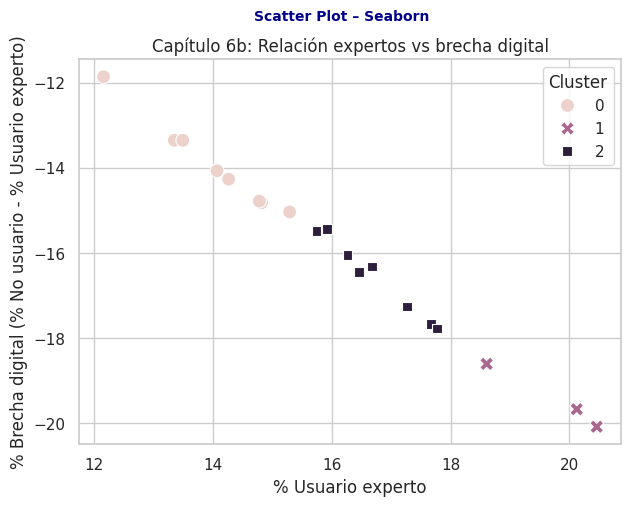


ℹ️ 6b) Aquí vemos la relación entre % de expertos y la brecha digital (No usuarios – Expertos).
     → Los clusters están diferenciados por color, pero al ser estático no se identifica cada CCAA individualmente.





ℹ️ 6c) Este gráfico compara los promedios de cada cluster: % de expertos y brecha digital media.
     → Permite ver qué grupos están más rezagados (menos expertos y brecha más alta) o más avanzados.




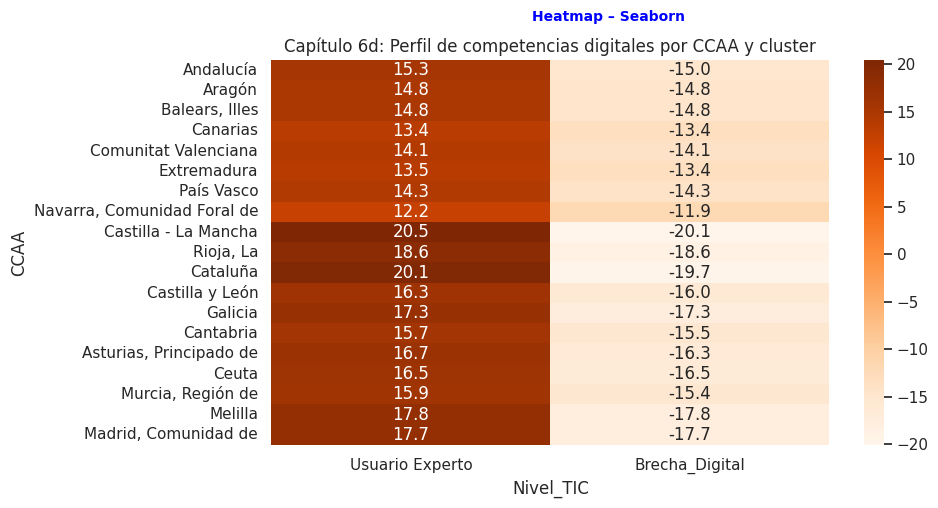


ℹ️ 6d) Este mapa de calor muestra los valores exactos por CCAA (% expertos y brecha digital), agrupados por cluster.
     → Facilita comparar entre comunidades dentro de un mismo cluster.


🔹 Cluster 0: Andalucía, Aragón, Balears, Illes, Canarias, Comunitat Valenciana, Extremadura, Navarra, Comunidad Foral de, País Vasco
🔹 Cluster 1: Castilla - La Mancha, Cataluña, Rioja, La
🔹 Cluster 2: Asturias, Principado de, Cantabria, Castilla y León, Ceuta, Galicia, Madrid, Comunidad de, Melilla, Murcia, Región de
ℹ️ Cluster 0: 8 CCAA, promedio 14.0% expertos, brecha -13.9 pp → nivel medio con brecha moderada.
ℹ️ Cluster 1: 3 CCAA, promedio 19.7% expertos, brecha -19.5 pp → nivel medio con brecha moderada.
ℹ️ Cluster 2: 8 CCAA, promedio 16.7% expertos, brecha -16.6 pp → nivel medio con brecha moderada.







📖 STORYTELLING FINAL – INSIGHTS Y RECOMENDACIONES
                                                     

🔵 WHAT: Sólo el 16.5% de estudiantes alcanza nivel experto TIC; mientras que un preo

In [ ]:
# ========================================================
# STORYTELLING – MULTI-HERRAMIENTA CON DATOS CONCRETOS
# Storytelling con datos – La brecha digital en la ESO
# ========================================================

# -------------------------
# 1. PANORAMA NACIONAL (Seaborn)
# -------------------------
df_nacional = df_long[(df_long["CCAA"]=="Total Nacional") &
                      (df_long["Sexo"]=="Total") &
                      (df_long["Tipo_Centro"]=="Total")]

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=df_nacional, x="Nivel_TIC", y="Porcentaje", palette="Blues_d", ax=ax)

plt.suptitle("Gráfico de Barras – Seaborn", fontsize=10, fontweight="bold", color="blue")
ax.set_title("Capítulo 1: Distribución de niveles TIC (Nacional)", fontsize=12, fontweight="bold")

ax.set_ylabel("% estudiantes", fontsize=12)
ax.set_xlabel("Nivel TIC", fontsize=12)

ax.tick_params(axis="x", labelsize=9, labelcolor="black")
ax.tick_params(axis="y", labelsize=11, labelcolor="black")

plt.show()
print("")

# -------------------------
# Comentario narrativo
# -------------------------
# Extraemos valores concretos usando los nombres correctos de Nivel_TIC from df_long
try:
    experto_pct = df_nacional[df_nacional["Nivel_TIC"]=="Usuario Experto"]["Porcentaje"].values[0]
except IndexError:
    experto_pct = None

try:
    avanzado_pct = df_nacional[df_nacional["Nivel_TIC"]=="Usuario Avanzado"]["Porcentaje"].values[0]
except IndexError:
    avanzado_pct = None

try:
    basico_pct  = df_nacional[df_nacional["Nivel_TIC"]=="Usuario Basico"]["Porcentaje"].values[0] # Corrected spelling
except IndexError:
    basico_pct = None

if experto_pct is not None and avanzado_pct is not None and basico_pct is not None:
    print(f"ℹ️ A nivel nacional: {experto_pct:.1f}% son expertos TIC, {avanzado_pct:.1f}% son avanzados TIC, mientras {basico_pct:.1f}% se quedan en nivel básico.")
    print("")
    print("")
else:
    print("ℹ️ Could not retrieve all national percentages.")
    print("")
    print("")


# -------------------------
# 2. BRECHA DE GÉNERO: Expertos y Avanzados
# -------------------------

# -------------------------
# 2a) Brecha de género % global (Altair – Variante horizontal)
# -------------------------

chart_gen = alt.Chart(df_genero).mark_bar().encode(
    x=alt.X("Sexo", title=None),
    y=alt.Y("Porcentaje", title="% Estudiantes"),
    color="Sexo",
    tooltip=["Sexo","Nivel_TIC","Porcentaje"]
).facet(
    column="Nivel_TIC"
).properties(
    title=" Barras – Altair | Capítulo 2a: Brecha de género (Nacional)"
).configure_axis(
    labelFontSize=13,
    titleFontSize=10,
    titleFontWeight="bold"
).configure_title(
    fontSize=16,
    fontWeight="bold",
    color="blue"
).configure_view(
    continuousWidth=220,
    continuousHeight=250
)

chart_gen.display()
print("")
print("")


# -------------------------
# 2b) Brecha de género % global (Altair – Variante horizontal)
# -------------------------

# Filtramos para quedarnos solo con Experto, Avanzado y Básico
df_genero_filtrado = df_genero[
    ~df_genero["Nivel_TIC"].isin(["No Consta", "No Usuario"])
]

chart_gen_h = alt.Chart(df_genero_filtrado).mark_bar().encode(
    y=alt.Y("Sexo", title="Sexo"),
    x=alt.X("Porcentaje", title="% Estudiantes"),
    color="Sexo",
    tooltip=["Sexo","Nivel_TIC","Porcentaje"]
).facet(
    column="Nivel_TIC"
).properties(
    title="Barras horizontales – Altair | Capítulo 2b (Horizontal): Brecha de género (sin 'No Consta' ni 'No Usuario')"
).configure_axis(
    labelFontSize=13,
    titleFontSize=14,
    titleFontWeight="bold"
).configure_title(
    fontSize=16,
    fontWeight="bold",
    color="blue"
).configure_view(
    continuousWidth=240,   # más ancho para que entre el texto
    continuousHeight=280
)

chart_gen_h.display()
print("")
print("")

# -------------------------
# Comentario narrativo brecha género User Expertos TIC
# -------------------------
# Valores concretos
# Expertos
try:
    exp_hombres = df_genero[(df_genero["Sexo"]=="Hombres") &
                            (df_genero["Nivel_TIC"]=="Usuario Experto")]["Porcentaje"].values[0]
except IndexError:
    exp_hombres = None

try:
    exp_mujeres = df_genero[(df_genero["Sexo"]=="Mujeres") &
                            (df_genero["Nivel_TIC"]=="Usuario Experto")]["Porcentaje"].values[0]
except IndexError:
    exp_mujeres = None

if exp_hombres is not None and exp_mujeres is not None:
    print(f"🚹🚺 Expertos TIC → Hombres: {exp_hombres:.1f}%, Mujeres: {exp_mujeres:.1f}% → Brecha: {(exp_hombres-exp_mujeres):.1f} puntos.")
else:
    print("🚹🚺 No se pudo obtener el porcentaje de género para Expertos TIC.")

# -------------------------
# Comentario narrativo brecha género User Avanzados TIC
# -------------------------
# Valores concretos
# Avanzados
try:
    avanz_hombres = df_genero[(df_genero["Sexo"]=="Hombres") &
                              (df_genero["Nivel_TIC"]=="Usuario Avanzado")]["Porcentaje"].values[0]
except IndexError:
    avanz_hombres = None

try:
    avanz_mujeres = df_genero[(df_genero["Sexo"]=="Mujeres") &
                              (df_genero["Nivel_TIC"]=="Usuario Avanzado")]["Porcentaje"].values[0]
except IndexError:
    avanz_mujeres = None

if avanz_hombres is not None and avanz_mujeres is not None:
    print(f"🚹🚺 Avanzados TIC → Hombres: {avanz_hombres:.1f}%, Mujeres: {avanz_mujeres:.1f}% → Brecha: {(avanz_hombres-avanz_mujeres):.1f} puntos.")
else:
     print("🚹🚺 No se pudo obtener el porcentaje de género para Avanzados TIC.")
print("")
print("")


# 2.c) Barras dinámicas por CCAA (Plotly – horizontales)
df_ccaa_genero = df_long[
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["Sexo"].isin(["Hombres","Mujeres"])) &
    (df_long["Nivel_TIC"]=="Usuario Experto") &
    (df_long["CCAA"]!="Total Nacional")
]

fig = px.bar(
    df_ccaa_genero,
    y="CCAA", x="Porcentaje",  # <-- barras horizontales
    color="Sexo",
    barmode="group",
    orientation="h",
    labels={"Porcentaje":"% Estudiantes", "CCAA":"Comunidades Autónomas"},
    height=700,
    width=800
)

fig.update_layout(
    bargap=0.25,
    title=dict(
        text="Barras horizontales – Plotly<br><sup>Capítulo 2c: % Usuarios Expertos por CCAA y género</sup>",
        x=0.5,
        font=dict(size=14, color="blue")
    ),
    xaxis=dict(title="% Estudiantes", titlefont=dict(size=13, color="black")),
    yaxis=dict(title="CCAA", titlefont=dict(size=13, color="black"))
)

fig.show()
print("")

# -------------------------
# Comentario narrativo
# -------------------------
print("\nℹ️ Brecha de género por CCAA (nivel experto TIC)")
ccaa_diff = df_ccaa_genero.pivot(index="CCAA", columns="Sexo", values="Porcentaje").dropna()
for ccaa, row in ccaa_diff.iterrows():
    diff = row["Hombres"] - row["Mujeres"]
    signo = "mayor en Hombres" if diff > 0 else "mayor en Mujeres"
    print(f"- {ccaa}: {abs(diff):.1f} pp {signo}")

print("")
print("")


# -------------------------
# 3. CENTROS EDUCATIVOS
# -------------------------

# -------------------------
# 3a) Comparación nacional por tipo de centro (Altair, barras agrupadas, sin 'No Usuario' ni 'No Consta')
# -------------------------


# Filtramos Total Nacional, Sexo Total, pero quitamos "Total" de Tipo_Centro
df_centros = df_long[
    (df_long["CCAA"]=="Total Nacional") &
    (df_long["Sexo"]=="Total") &
    (df_long["Tipo_Centro"]!="Total") &
    (~df_long["Nivel_TIC"].isin(["No Usuario","No Consta"]))   # Quitamos categorías poco útiles
]

# Gráfico: barras agrupadas (grouped bar chart)
# Gráfico: barras agrupadas
chart_centros = alt.Chart(df_centros).mark_bar(size=40).encode(
    x=alt.X("Nivel_TIC:N",
            title="Nivel de Competencia Digital",
            sort=["Usuario Experto", "Usuario Avanzado", "Usuario Basico"],
            axis=alt.Axis(labelAngle=0)),
    y=alt.Y("Porcentaje:Q", title="% Estudiantes"),
    xOffset="Tipo_Centro",   # <- Clave para que se agrupen en vez de apilarse
    color=alt.Color("Tipo_Centro:N", title="Tipo de Centro"),
    tooltip=["Tipo_Centro", "Nivel_TIC", "Porcentaje"]
).properties(
    title={
        "text": ["Barras – Altair", "Capítulo 3a: Comparación público vs privado (Nacional)"],
        "subtitleColor": "blue",
        "subtitleFontSize": 12
    },
    width=350,
    height=350
).configure_axis(
    labelFontSize=12,
    titleFontSize=13,
    titleFontWeight="bold"
).configure_title(
    fontSize=14,
    fontWeight="bold"
)

chart_centros.display()
print("")

# -------------------------
# Comentario narrativo
# -------------------------
print("\nℹ️ Comparación Nacional – Público vs Privado (nivel TIC)")
pivot_centros = df_centros.pivot(index="Nivel_TIC", columns="Tipo_Centro", values="Porcentaje").dropna()
for nivel, row in pivot_centros.iterrows():
    diff = row["Centro Privado"] - row["Centro Público"]
    if diff > 0:
        print(f"- En {nivel}, los privados superan a los públicos por {diff:.1f} pp.")
    else:
        print(f"- En {nivel}, los públicos superan a los privados por {abs(diff):.1f} pp.")
print("")
print("")


# -------------------------
# 3b) Barras por CCAA (Plotly)
# -------------------------

# Filtramos Total Nacional, Sexo Total, pero quitamos "Total" de Tipo_Centro
df_ccaa_centro = df_long[
    (df_long["Sexo"]=="Total") &
    (df_long["Tipo_Centro"]!="Total") &
    (df_long["Nivel_TIC"]=="Usuario Experto") &
    (df_long["CCAA"]!="Total Nacional")
]

fig = px.bar(
    df_ccaa_centro,
    x="CCAA", y="Porcentaje",
    color="Tipo_Centro",
    barmode="group",
    title="Capítulo 3b: % Usuarios Expertos por CCAA y tipo de centro",
    labels={"Porcentaje":"% Estudiantes"}
)

# Personalizamos diseño
fig.update_layout(
    title=dict(
        text="Barras – Plotly<br><sup>Capítulo 3b: % Usuarios Expertos por CCAA y tipo de centro</sup>",
        x=0.5,
        font=dict(size=14, color="blue")
    ),
    xaxis=dict(tickangle=-45, tickfont=dict(size=11)),   # Rotamos nombres de CCAA
    yaxis=dict(titlefont=dict(size=12, color="black"), tickfont=dict(size=11)),
    legend=dict(title="Tipo de Centro", font=dict(size=11))
)

# Opcional: mostrar valores encima de las barras
fig.update_traces(texttemplate='%{y:.1f}', textposition='outside')

fig.show()
print("")

# -------------------------
# Comentario narrativo
# -------------------------
print("\nℹ️ Comparación CCAA – Público vs Privado en usuarios expertos TIC")
pivot_ccaa = df_ccaa_centro.pivot(index="CCAA", columns="Tipo_Centro", values="Porcentaje").dropna()
for ccaa, row in pivot_ccaa.iterrows():
    diff = row["Centro Privado"] - row["Centro Público"]
    if diff > 0:
        print(f"- {ccaa}: privados superan a públicos en {diff:.1f} pp.")
    else:
        print(f"- {ccaa}: públicos superan a privados en {abs(diff):.1f} pp.")

print("")
print("")


# -------------------------
# 4. BRECHA TERRITORIAL (Bokeh)
# -------------------------
from bokeh.models import ColumnDataSource, HoverTool, LabelSet
from bokeh.plotting import figure, show

# Filtrar datos
df_ccaa_bokeh = df_long[
    (df_long["Sexo"]=="Total") &
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["CCAA"]!="Total Nacional") &
    (df_long["Nivel_TIC"]=="Usuario Experto")
]

# Ordenamos CCAA por % de expertos (descendente)
df_ccaa_bokeh = df_ccaa_bokeh.sort_values("Porcentaje", ascending=False)

# Redondeamos porcentajes a 1 decimal para las etiquetas
df_ccaa_bokeh["Porcentaje_lbl"] = df_ccaa_bokeh["Porcentaje"].round(1).astype(str)

# Fuente para Bokeh
source = ColumnDataSource(df_ccaa_bokeh)

# Gráfico
p = figure(
    x_range=df_ccaa_bokeh["CCAA"].tolist(),
    title="Barras – Bokeh | Capítulo 4: % Usuarios Expertos por CCAA",
    height=450, width=850,
    toolbar_location=None, tools=""
)

p.vbar(x="CCAA", top="Porcentaje", source=source, width=0.8, color="orange")

# Hover interactivo
hover = HoverTool(tooltips=[("CCAA","@CCAA"), ("% Expertos","@Porcentaje{0.1f}")])
p.add_tools(hover)

# Etiquetas encima de cada barra
labels = LabelSet(
    x="CCAA", y="Porcentaje", text="Porcentaje_lbl",
    level="glyph", x_offset=-10, y_offset=6,
    source=source,
    text_font_size="9pt", text_font_style="bold"
)
p.add_layout(labels)


# Esilo título
p.title.text_font_size = "11pt"
p.title.text_color = "darkblue"
p.title.align = "center"
p.title.offset = 200

# Ejes
p.xaxis.major_label_orientation = 1.2
p.xaxis.axis_label = "CCAA"
p.yaxis.axis_label = "% Estudiantes expertos TIC"
p.xaxis.axis_label_text_font_size = "11pt"
p.yaxis.axis_label_text_font_size = "11pt"
p.xaxis.axis_label_text_font_style = "bold"
p.yaxis.axis_label_text_font_style = "bold"

show(p)
print("")

# -------------------------
# Comentario narrativo (Top 3 y Bottom 3)
# -------------------------
print("🏆 Top 3 CCAA con mayor % de usuarios expertos TIC:")
for _, row in df_ccaa_bokeh.head(3).iterrows():
    print(f"   - {row['CCAA']}: {row['Porcentaje']:.1f}%")

print("\n📉 Bottom 3 CCAA con menor % de usuarios expertos TIC:")
for _, row in df_ccaa_bokeh.tail(3).iterrows():
    print(f"   - {row['CCAA']}: {row['Porcentaje']:.1f}%")

print("")
print("")

# -------------------------
# 5. RANKINGS TOP/BOTTOM (Altair)
# -------------------------

df_scope = df_long[(df_long["Sexo"]=="Total") &
                   (df_long["Tipo_Centro"]=="Total") &
                   (df_long["CCAA"]!="Total Nacional") &
                   (df_long["Nivel_TIC"]=="Usuario Experto")]

top3 = df_scope.nlargest(3,"Porcentaje")
bottom3 = df_scope.nsmallest(3,"Porcentaje")

rank_data = pd.concat([top3.assign(Rank="Top 3"), bottom3.assign(Rank="Bottom 3")])

chart_rank = alt.Chart(rank_data).mark_bar(size=25).encode(
    x=alt.X("Porcentaje:Q", title="% Estudiantes expertos TIC"),
    y=alt.Y("CCAA:N", sort='-x', title="CCAA"),
    color=alt.Color("Rank:N", scale=alt.Scale(scheme="set1"), legend=alt.Legend(title="Grupo")),
    tooltip=["CCAA","Porcentaje","Rank"]
).properties(
    title="Barras – Altair | Capítulo 5: Ranking CCAA – Usuarios expertos (Top/Bottom 3)",
    width=500,
    height=300
)

# Etiquetas encima de cada barra
text = chart_rank.mark_text(
    align="left",
    baseline="middle",
    dx=3,
    fontSize=12,
    fontWeight="bold"
).encode(
    text=alt.Text("Porcentaje:Q", format=".1f")
)

(chart_rank + text).configure_axis(
    labelFontSize=12,
    titleFontSize=13,
    titleFontWeight="bold"
).configure_title(
    fontSize=14,
    fontWeight="bold",
    anchor="middle",
    color="darkblue"
).display()

# -------------------------
# Comentario narrativo
# -------------------------
print("🏆 Top 3 CCAA con mayor % de usuarios expertos TIC:")
for _, row in top3.iterrows():
    print(f"   - {row['CCAA']}: {row['Porcentaje']:.1f}%")

print("\n📉 Bottom 3 CCAA con menor % de usuarios expertos TIC:")
for _, row in bottom3.iterrows():
    print(f"   - {row['CCAA']}: {row['Porcentaje']:.1f}%")


print("🏆 Top 3 CCAA con mayor % de usuarios expertos TIC:")
for _, row in top3.iterrows():
    print(f"   - {row['CCAA']}: {row['Porcentaje']:.1f}%")

print("\n📉 Bottom 3 CCAA con menor % de usuarios expertos TIC:")
for _, row in bottom3.iterrows():
    print(f"   - {row['CCAA']}: {row['Porcentaje']:.1f}%")

print("")
print("")


# -------------------------
# 6. CLUSTERS (Seaborn scatter + Barplot + Heatmap)
# -------------------------

from sklearn.cluster import KMeans

# 1. Preparamos df_ccaa_cluster
df_ccaa_cluster = df_long[
    (df_long["Sexo"]=="Total") &
    (df_long["Tipo_Centro"]=="Total") &
    (df_long["CCAA"]!="Total Nacional")
].pivot(index='CCAA', columns='Nivel_TIC', values='Porcentaje').reset_index()

# Calculamos brecha digital = No Usuario - Usuario Experto
df_ccaa_cluster["Brecha_Digital"] = df_ccaa_cluster["No Usuario"] - df_ccaa_cluster["Usuario Experto"]

# Clustering con KMeans
X = df_ccaa_cluster[["Usuario Experto", "Brecha_Digital"]]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
df_ccaa_cluster["Cluster"] = kmeans.labels_

# -------------------------
# Gráfico 6a – Scatter Plotly
# -------------------------
fig = px.scatter(
    df_ccaa_cluster,
    x="Usuario Experto",
    y="No Usuario",
    color="Cluster",
    hover_name="CCAA",
    title="Scatter – Plotly<br><sup>Capítulo 6a: Clusters de CCAA según nivel TIC</sup>",
    labels={"Usuario Experto": "% Expertos", "No Usuario": "% No Usuarios"},
    size_max=10
)
fig.update_traces(text=df_ccaa_cluster["CCAA"], textposition="top center")
fig.show()
print("")

# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ 6a) Este gráfico interactivo (Plotly) muestra cómo se distribuyen las CCAA según % de usuarios expertos y no usuarios.")
print("     → Permite identificar de manera visual los clusters y consultar cada comunidad pasando el ratón.")
print("")
print("")


# -------------------------
# Gráfico 6b – Scatter técnico Seaborn
# -------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_ccaa_cluster,
    x="Usuario Experto", y="Brecha_Digital",
    hue="Cluster", style="Cluster", s=100
)
plt.suptitle("Scatter Plot – Seaborn", fontsize=10, fontweight="bold", color="darkblue")
plt.title("Capítulo 6b: Relación expertos vs brecha digital")
plt.xlabel("% Usuario experto")
plt.ylabel("% Brecha digital (% No usuario - % Usuario experto)")
plt.show()
print("")


# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ 6b) Aquí vemos la relación entre % de expertos y la brecha digital (No usuarios – Expertos).")
print("     → Los clusters están diferenciados por color, pero al ser estático no se identifica cada CCAA individualmente.")
print("")
print("")


# -------------------------
# Gráfico 6c – Barplot promedio por cluster (Plotly)
# -------------------------
df_cluster_summary = df_ccaa_cluster.groupby("Cluster")[["Usuario Experto","Brecha_Digital"]].mean().reset_index()
fig = px.bar(
    df_cluster_summary,
    x="Cluster", y=["Usuario Experto","Brecha_Digital"],
    barmode="group",
    title="Barras – Plotly<br><sup>Capítulo 6c: Promedio de expertos y brecha digital por cluster</sup>",
    labels={"value":"% promedio","variable":"Indicador"}
)
fig.show()
print("")


# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ 6c) Este gráfico compara los promedios de cada cluster: % de expertos y brecha digital media.")
print("     → Permite ver qué grupos están más rezagados (menos expertos y brecha más alta) o más avanzados.")
print("")
print("")



# -------------------------
# Gráfico 6d – Heatmap comparativo (Seaborn)
# -------------------------
df_heatmap = df_ccaa_cluster.set_index("CCAA")[["Usuario Experto","Brecha_Digital","Cluster"]]
df_heatmap_sorted = df_heatmap.sort_values("Cluster")

plt.figure(figsize=(9,5))
sns.heatmap(df_heatmap_sorted.drop(columns="Cluster"), annot=True, fmt=".1f", cmap="Oranges")
plt.suptitle("Heatmap – Seaborn", fontsize=10, fontweight="bold", color="blue")
plt.title("Capítulo 6d: Perfil de competencias digitales por CCAA y cluster")
plt.ylabel("CCAA")
plt.show()
print("")

# -------------------------
# Comentario narrativo
# -------------------------
print("ℹ️ 6d) Este mapa de calor muestra los valores exactos por CCAA (% expertos y brecha digital), agrupados por cluster.")
print("     → Facilita comparar entre comunidades dentro de un mismo cluster.")
print("")
print("")

# -------------------------
# Agrupación de comunidades por cluster
# -------------------------
for cluster in sorted(df_ccaa_cluster["Cluster"].unique()):
    ccaa_list = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster]["CCAA"].tolist()
    print(f"🔹 Cluster {cluster}: {', '.join(ccaa_list)}")

# -------------------------
# Comentario narrativo automático sobre clusters
# -------------------------
for cluster in sorted(df_ccaa_cluster["Cluster"].unique()):
    n_ccaa = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster].shape[0]
    avg_exp = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster]["Usuario Experto"].mean()
    avg_brecha = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster]["Brecha_Digital"].mean()

    # Clasificación automática de perfiles
    if avg_exp > 20 and avg_brecha < 5:
        perfil = "alto nivel digital y baja brecha (líderes)"
    elif 10 <= avg_exp <= 20:
        perfil = "nivel medio con brecha moderada"
    else:
        perfil = "rezago digital, baja proporción de expertos y brecha alta"

    print(f"ℹ️ Cluster {cluster}: {n_ccaa} CCAA, promedio {avg_exp:.1f}% expertos, brecha {avg_brecha:.1f} pp → {perfil}.")
print("")
print("")
print("")
print("")

# Exportamos para storytelling final
df_ccaa_cluster.rename(columns={
    "usuario_experto": "Usuario_Experto_Pct",
    "brecha_digital": "Brecha_Digital_Pct"
}).to_csv("ccaa_clusters.csv", index=False)
print("")
print("")

# -------------------------
# 7. RESUMEN NARRATIVO
# -------------------------
print("=====================================================")
print("=====================================================")
print("\n📖 STORYTELLING FINAL – INSIGHTS Y RECOMENDACIONES")
print("                                                     ")
print("=====================================================")
print("=====================================================")
print("")

# WHAT
if experto_pct is not None and basico_pct is not None:
    print(f"🔵 WHAT: Sólo el {experto_pct:.1f}% de estudiantes alcanza nivel experto TIC; "
          f"mientras que un preocupante ({basico_pct:.1f}%) se quedan en nivel básico ({basico_pct:.1f}%).")
else:
    print("🔵 WHAT: No se pudieron recuperar los porcentajes nacionales.")
print("")
print("")

# WHY
if exp_hombres is not None and exp_mujeres is not None:
    print(f"🟠 WHY: ¿Por qué sucede esto?: La brecha de género en expertos es de {(exp_hombres-exp_mujeres):.1f} pp "
          f"(hombres {exp_hombres:.1f}% vs mujeres {exp_mujeres:.1f}%).")
else:
     print(" • Why: No se pudieron recuperar datos de género para expertos TIC.")

if avanz_hombres is not None and avanz_mujeres is not None:
     print(f"     • En **avanzados** la brecha se reduce a {(avanz_hombres-avanz_mujeres):.1f} pp "
           f"(hombres {avanz_hombres:.1f}% vs mujeres {avanz_mujeres:.1f}%).")
else:
      print(" • Why: No se pudieron recuperar datos de género para avanzados TIC.")

print("    •  Los centros privados muestran ventaja sobre los públicos a nivel experto.")
print("    •  Y hay fuertes desigualdades territoriales (Top 3 vs Bottom 3 CCAA).")
print("")
print("")

# CLUSTERS (Add narrative based on clusters if clustering was successful)
if 'df_ccaa_cluster' in locals() and 'Cluster' in df_ccaa_cluster.columns:
    print("     Además, el análisis de clusters revela 3 perfiles de CCAA:")
    print("")
    print("     📌 Nota: La brecha digital se define como (% No Usuario – % Usuario Experto).")
    print("        • Valores positivos = más rezago que excelencia (riesgo digital).")
    print("        • Valores cercanos a 0 = equilibrio entre expertos y rezagados.")
    print("        • Valores negativos = liderazgo: más expertos que no usuarios.")
    print("")

    # Ordenamos clusters por % de expertos (de mayor a menor)
    cluster_order = df_ccaa_cluster.groupby("Cluster")["Usuario Experto"].mean().sort_values(ascending=False)

    # Etiquetas dinámicas
    labels = {
        cluster_order.index[0]: "💡 Alto nivel digital y baja brecha (líderes en TIC)",
        cluster_order.index[1]: "⚖️ Nivel intermedio con brecha moderada",
        cluster_order.index[2]: "🚨 Rezago digital: baja proporción de expertos y alta brecha"
    }

    # Recorremos clusters en orden
    for cluster in cluster_order.index:
        n_ccaa = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster].shape[0]
        avg_exp = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster]["Usuario Experto"].mean()
        avg_brecha = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster]["Brecha_Digital"].mean()
        ccaa_list = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster]["CCAA"].tolist()

        print(f"       • Grupo {cluster}: {labels[cluster]}")
        print(f"         – {n_ccaa} CCAA → {avg_exp:.1f}% expertos, brecha media {avg_brecha:.1f} pp.")
        print(f"         – CCAA incluidas: {', '.join(ccaa_list)}")

else:
    print("     ℹ️ No pudo completarse el análisis de Cluster.")
print("")
print("")

# SO WHAT
print("🚨 SO WHAT: Se requieren medidas urgentes y diferenciadas según el perfil territorial:")
print("")
print("   1. 👩‍💻 Programas STEM y mentoría para mujeres, especialmente en la transición Avanzado → Experto.")
print("")
print("   2. 🏫 Mayor inversión TIC en centros públicos para reducir la brecha con los privados.")
print("")
print("   3. 🇪🇸 Estrategia nacional para reducir desigualdades entre CCAA (España de varias velocidades digitales).")
print("")
print("   4. 👨‍🏫 Formación docente continua en competencias digitales.")
print("")
if 'df_ccaa_cluster' in locals() and 'Cluster' in df_ccaa_cluster.columns:
     print("   5. 📌 Planes regionales adaptados a cada cluster:")
     print("")
     print("        – Refuerzo intensivo en comunidades rezagadas (Cluster de rezago digital).")
     print("        – Consolidación de buenas prácticas en clusters intermedios.")
     print("        – Liderazgo internacional y compartición de experiencias en los clusters avanzados.")

**Paso 8. Exportación de datos y gráficos**

En este paso generamos los artefactos para reutilizar el análisis y la historia en diferentes contextos:

**1. Exportar datasets limpios**
   * **CSV** → para Tableau o Power BI (dashboards interactivos).
   * **JSON** → para D3.js (visualizaciones web personalizadas).
   
**2. Exportar visualizaciones**
   * **Matplotlib / Seaborn** → PNG o JPG (gráficos estáticos).
   * **Plotly** → HTML interactivo (para incrustar en Medium, blogs o webs)
   * **Altair** → HTML o JSON (compatible con Vega / Vega-Lite).
   * **Bokeh** → HTML (dashboards interactivos empresariales).

**Usos posibles:**

* **CSV → Tableau/Power BI**: construir dashboards interactivos.
* **HTML (Plotly, Altair, Bokeh)**: incrustar en páginas web o Medium.
* **PNG/JPG**: usar en Canva o informes PDF.


In [ ]:
# 1. Exportar datasets limpios (para Tableau o Power BI)
df_long.to_csv("graduados_tic_limpio.csv", index=False)
print("✅ Dataset exportado a graduados_tic_limpio.csv")

# También exportar en JSON (para D3.js)
df_long.to_json("graduados_tic_limpio.json", orient="records", force_ascii=False)
print("✅ Dataset exportado a graduados_tic_limpio.json")

# 2. Matplotlib / Seaborn → PNG o JPG
plt.figure(figsize=(6,4))
sns.barplot(data=df_nacional, x="Nivel_TIC", y="Porcentaje")
plt.title("Distribución nacional de habilidades TIC (ESO)")
plt.savefig("grafico_seaborn.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Gráfico Seaborn exportado a grafico_seaborn.png")

# 3. Plotly → HTML interactivo
fig_plotly = px.bar(df_nacional, x="Nivel_TIC", y="Porcentaje",
                    title="Distribución nacional interactiva",
                    labels={"Porcentaje":"% estudiantes"})
fig_plotly.write_html("grafico_plotly.html")
print("✅ Gráfico Plotly exportado a grafico_plotly.html")

# 4. Altair → HTML o JSON (Vega compatible)
chart.save("grafico_altair.html")
chart.save("grafico_altair.json")
print("✅ Gráfico Altair exportado a grafico_altair.html y grafico_altair.json")

# 5. Bokeh → HTML (dashboards)
from bokeh.resources import CDN
from bokeh.embed import file_html

html_bokeh = file_html(p, CDN, "grafico_bokeh")
with open("grafico_bokeh.html", "w") as f:
    f.write(html_bokeh)
print("✅ Gráfico Bokeh exportado a grafico_bokeh.html")


✅ Dataset exportado a graduados_tic_limpio.csv
✅ Dataset exportado a graduados_tic_limpio.json
✅ Gráfico Seaborn exportado a grafico_seaborn.png
✅ Gráfico Plotly exportado a grafico_plotly.html
✅ Gráfico Altair exportado a grafico_altair.html y grafico_altair.json
✅ Gráfico Bokeh exportado a grafico_bokeh.html


**Paso 9. Informe Ejecutivo**

In [ ]:
# ========================================================
# INFORME EJECUTIVO – STORYTELLING EN TEXTO
# ========================================================

informe = f"""
# 📖 Informe Ejecutivo – Brecha Digital en la ESO (INE 43698)

## 🌍 Panorama nacional
- Solo **{experto_pct:.1f}%** de estudiantes alcanza el nivel **experto TIC**.
- Un preocupante **{basico_pct:.1f}%** se queda en nivel **básico**, lo que limita su empleabilidad futura.

## 🚹🚺 Brecha de género
- Expertos TIC → Hombres: **{exp_hombres:.1f}%**, Mujeres: **{exp_mujeres:.1f}%**.
- Diferencia: **{(exp_hombres-exp_mujeres):.1f} pp**.
- Aunque en el nivel avanzado las mujeres reducen la distancia, la brecha persiste en el acceso a la excelencia digital.

## 🏫 Centros educativos
- Los centros **privados** superan a los **públicos** en % de estudiantes expertos.
- Esto evidencia desigualdades socioeconómicas en el acceso y calidad de la educación digital.

## 🗺️ Brecha territorial
- Existen **grandes desigualdades entre comunidades autónomas**:
  - 🏆 **Top 3 CCAA con mayor % de expertos:**
{chr(10).join([f"    - {row['CCAA']}: {row['Porcentaje']:.1f}%" for _, row in top3.iterrows()])}

  - 📉 **Bottom 3 CCAA con menor % de expertos:**
{chr(10).join([f"    - {row['CCAA']}: {row['Porcentaje']:.1f}%" for _, row in bottom3.iterrows()])}

## 🔎 Clusters territoriales
- El análisis agrupa las CCAA según % de expertos TIC y brecha digital
  (definida como diferencia entre % de No Usuario y % de Usuario Experto).

"""

# Añadimos dinámicamente el detalle de clusters
if 'df_ccaa_cluster' in locals() and 'Cluster' in df_ccaa_cluster.columns:
    for cluster in sorted(df_ccaa_cluster["Cluster"].unique()):
        ccaa_list = df_ccaa_cluster[df_ccaa_cluster["Cluster"]==cluster][["CCAA","Usuario Experto","Brecha_Digital"]]
        avg_exp = ccaa_list["Usuario Experto"].mean()
        avg_brecha = ccaa_list["Brecha_Digital"].mean()

        # Explicación de la brecha
        if avg_brecha < 0:
            brecha_txt = "brecha negativa → más expertos que no usuarios (perfil avanzado)"
        elif avg_brecha < 10:
            brecha_txt = "brecha moderada → equilibrio relativo entre expertos y no usuarios"
        else:
            brecha_txt = "brecha alta → exceso de no usuarios frente a expertos (rezago)"

        # Comunidad más rezagada y más experta en este cluster
        worst_ccaa = ccaa_list.sort_values("Usuario Experto").iloc[0]
        best_ccaa = ccaa_list.sort_values("Usuario Experto").iloc[-1]

        informe += f"""
### 🟢 Cluster {cluster}
- Promedio de expertos: **{avg_exp:.1f}%**, brecha media: **{avg_brecha:.1f} pp** → {brecha_txt}.
- CCAA incluidas: {', '.join(ccaa_list['CCAA'].tolist())}
- Más rezagada: **{worst_ccaa['CCAA']}** ({worst_ccaa['Usuario Experto']:.1f}% expertos).
- Con mayor nivel experto: **{best_ccaa['CCAA']}** ({best_ccaa['Usuario Experto']:.1f}% expertos).
"""
else:
    informe += "\nℹ️ No se pudo calcular la información de clusters.\n"

# Continuamos con los insights y recomendaciones
informe += f"""

## 💡 Insights estratégicos
1. 🚨 **Crisis de competencias:** el bajo % de expertos amenaza la competitividad digital futura.
2. ⚖️ **Brecha de género:** las mujeres siguen rezagadas en la excelencia TIC.
3. 🏫 **Brecha público-privada:** urge reforzar la inversión TIC en centros públicos.
4. 🗺️ **Desigualdades territoriales:** requieren coordinación nacional y planes regionales.

## ✅ Recomendaciones
1. 💰 **Inversión prioritaria** en infraestructura y contenidos TIC en centros públicos.
2. 🎯 **Programas STEM para mujeres**, especialmente en la transición Avanzado → Experto.
3. 👥 **Formación docente continua** en competencias digitales.
4. 📱 **Garantizar conectividad y dispositivos** en todas las CCAA, priorizando las rezagadas.
5. 📊 **Dashboard público nacional** para monitorizar avances y reducir desigualdades.
6. 🗂️ **Planes regionales adaptados a cada cluster**, reforzando intensivamente a los territorios en rezago digital.
"""

# Guardar informe en TXT y Markdown
with open("informe_storytelling.txt","w",encoding="utf-8") as f:
    f.write(informe)

with open("informe_storytelling.md","w",encoding="utf-8") as f:
    f.write(informe)

print("✅ Informe ejecutivo exportado como informe_storytelling.txt y .md")


✅ Informe ejecutivo exportado como informe_storytelling.txt y .md


**Paso 9. Descarga el notebook desde Colab:**
File → Download → Download .ipynb.